# Guided-LDA Topic Modeling 

This notebook implements topic modeling using [guided or seeded LDA](https://github.com/vi3k6i5/GuidedLDA)

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
pd.set_option('display.width',-1)

In [62]:
# load data
df = pd.read_csv('../data/all_data.csv')
df.head()

,reviews,rating,company
0,Great card! We get cash back for our grocery a...,4.0,American Express Blue Cash Preferred
1,While traveling we had to keep calling the Cre...,1.0,Credit One Bank
2,Great card to have! Love all the additional cr...,5.0,Capital One Quicksilver Rewards
3,no tengo tanta experiencia asi que no puedo da...,2.0,Citi Double Cash Card
4,This is a basic credit card. The cash back dea...,4.0,Bank of America Cash Rewards Credit Card


In [63]:
df.shape

(25708, 3)

## Reviews  to sentences

In [64]:
def sentence(data, review, company):
    """Converts reviews to sentences and keeps track of company name for each sentence"""
    sentence_tokens = [[sentence for sentence in sent_tokenize(data[review].loc[i])] for i in range(len(data))]
    count_sentences = [len(x) for x in sentence_tokens] 
    sentences = [sentence for sub_sentence in sentence_tokens for sentence in sub_sentence]
    count_company = [[x] for x in data[company]]
    company_token = []
    for idx, val in enumerate(count_sentences):
        company_token.append(count_company[idx]*val)
    company_names = [name for names in company_token for name in names]
    return sentences, company_names

In [65]:
# Convert to dataframe
result = sentence(df, 'reviews', 'company')
df_rev_sen = pd.DataFrame({'sentence': result[0], 'company': result[1]}) 

In [66]:
df_rev_sen.shape

(111357, 2)

## Vader Sentiment Analysis

In [67]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [68]:
def score(sentence):
    """Returns the compound polarity (sentiment) score of each senetence"""
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(sentence)
    return score['compound']

In [69]:
# Sentiment of each sentence
df_rev_sen['sentiment'] = df_rev_sen.sentence.apply(score)

In [70]:
# Remove all the neutral sentiments with score of zero
df_sentence = df_rev_sen[df_rev_sen.sentiment !=0].reset_index(drop=True)

In [71]:
# Positive sentiments with s acore greater than 0.4 maps to 1 and 0 otherwise
df_sentence['positivity'] = np.where(df_sentence['sentiment'] > 0.4, 1, 0)

In [72]:
# Sort and save to csv file
df_sentence = df_sentence.sort_values(['company','sentiment'], ascending = False).reset_index(drop=True)
df_sentence.to_csv('../data/sentence.csv', index = False) 

In [2]:
# Reload saved data
df_sentence = pd.read_csv('../data/sentence.csv') 
df_sentence.head()

,sentence,company,sentiment,positivity
0,I CALLED AND ASKED THEM WHY I WAS GETTING INTE...,Walmart MASTERCARD,0.8647,1
1,Excellent rewards and redeem easily when makin...,Walmart MASTERCARD,0.8481,1
2,I must note that I had also received 2 previou...,Walmart MASTERCARD,0.8225,1
3,After 6 weeks and a few major purchases I was ...,Walmart MASTERCARD,0.7943,1
4,I have the Walmart Mastercard for over 2 years...,Walmart MASTERCARD,0.7845,1


In [74]:
df_sentence.shape

(84247, 4)

In [75]:
df_sentence.positivity.value_counts()

1    43759
0    40488
Name: positivity, dtype: int64

In [76]:
def print_review(index):
    """Display each row"""
    text = df_sentence[df_sentence.index ==index].values.reshape(4)
    sentence = text[0]
    company = text[1]
    sentiment = text[2]
    positivity = text[3]
    print('Sentence:',sentence)
    print('Credit card:',company)
    print('Sentiment:',sentiment)
    print('Positivity:',positivity)

print_review(100)

Sentence: Yes, I have one last statement that is not overdue but no apologies about this harassing letter that has no grounds.
Credit card: Walmart MASTERCARD
Sentiment: -0.29
Positivity: 0


In [3]:
# Calculate the mean sentiment of all credit card company
mean_senti = df_sentence.groupby('company')['sentiment'].mean().sort_values(ascending = False)
round(mean_senti,3).head()

company
Discover it Secured                         0.540
Discover it Miles                           0.538
Bank of America Cash Rewards Credit Card    0.513
Chase Freedom Unlimited                     0.498
Capital One Venture Rewards                 0.496
Name: sentiment, dtype: float64

Text(0, 0.5, 'count')

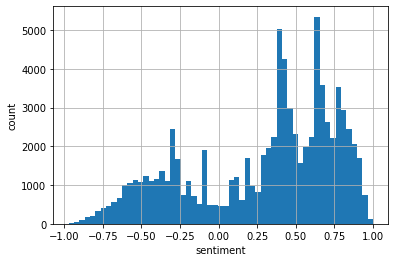

In [78]:
df_sentence.sentiment.hist(bins = 'auto')
plt.xlabel('sentiment')
plt.ylabel('count')

## Data Pre-processing

In [79]:
import guidedlda
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from collections import Counter

In [80]:
# By inspection we create a list of stopwords and add them to the usual nltk stopwords
my_stop_words = ['capital','america', 'redcard', 'target','amazon', 'card', 'credit','merrick', 'discover', 'citi',
                 'amex', 'express', 'go', 'paypal', 'chase', 'american', 'one', 'would', 'ask','really', 
                 'get', 'know', 'express', 'ever','use','say', 'recently', 'also', 'always', 'give',  'tell', 
                 'take', 'never', 'costco', 'time', 'make', 'try','number', 'send', 'new', 'even',
                 'sony', 'us', 'husband', 'car', 'capitol', 'wife', 'book','could','okay', 'mastercard', 'want',
                 'honestly', 'eppicard', 'need', 'family', 'cap', 'another', 'line', 'com', 'fico', 'quicksilver',
                'link', 'sear', 'pay', 'may', 'company', 'bank', 'call', 'account', 'receive','told', 'day', 'well',
                'think', 'look', 'sure', 'easy', 'money', 'people','business', 'review', 'something', 'come','away']

stop_words = stopwords.words('english')
stop_words.extend(my_stop_words)

In [81]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def word_lemmatizer(text):
    """Word lemmatization function"""
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text, get_wordnet_pos(text))
    return text

def my_tokenizer(text):
    """Tokenize review text"""
    text = text.lower() # lower case
    text = re.sub("\d+", " ", text) # remove digits
    tokenizer = RegexpTokenizer(r'\w+')
    token = [word for word in tokenizer.tokenize(text) if len(word)>2]
    token = [word_lemmatizer(x) for x in token]  
    token = [s for s in token if s not in stop_words]
    return token

In [82]:
def word_count(text):
    """Plot the most frequency words in the corpus"""
    all_reviews = ' '.join(text) # join all reviews
    token_count = Counter(my_tokenizer(all_reviews)) # count each word
    common_words =  dict( token_count.most_common(n=25) ) # count most common 20 words
    freq_plot = pd.Series(common_words, index=None).plot(kind = 'bar', figsize=(10,5))
    plt.ylabel('count')
    #plt.savefig('../figures/fig2.pdf')

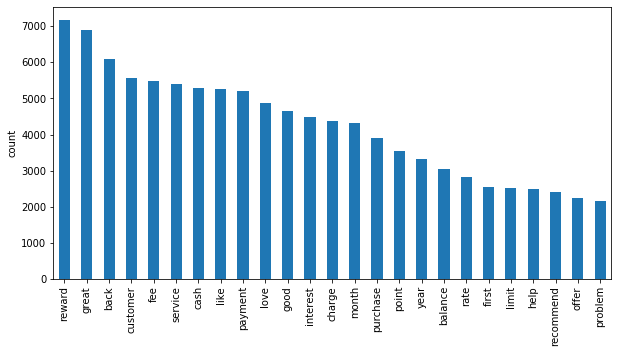

In [83]:
word_count(df_sentence.sentence)

# Topic Modeling with LDA

In [84]:
def doc_term_matrix(data, text):
    """Returns document term matrix, vocabulary, and word id"""
    counter = CountVectorizer(tokenizer=my_tokenizer, ngram_range = (1,1))
    X = counter.fit_transform(data[text]).toarray()
    bow_docs = pd.DataFrame(X, columns=counter.get_feature_names())
    vocab = tuple(bow_docs.columns)
    word2id = dict((v, idx) for idx, v in enumerate(vocab))
    return X, vocab, word2id

In [85]:
X, vocab, word2id = doc_term_matrix(df_sentence, 'sentence')

In [86]:
X.shape

(84247, 10964)

## 1. Sklearn LDA

In [87]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [88]:
lda = LDA(n_components=10, learning_method='batch')
lda.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [89]:
lda.components_.shape

(10, 10964)

In [90]:
topics = ['topic{}'.format(i) for i in range(lda.components_.shape[0])]
components = pd.DataFrame(lda.components_.T, index=vocab, columns = topics)/len(X)
n_top_words = 10
for i, topic_dist in enumerate(topics):
    topic_words = components[topics[i]].sort_values(ascending=False)[:n_top_words].index
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: back reward great cash love purchase best like earn travel
Topic 1: customer service good great helpful excellent benefit overall experience care
Topic 2: bad issue phone work happy someone security person speak talk
Topic 3: fee payment charge late annual month balance paid interest full
Topic 4: point recommend reward travel like anyone purchase lot definitely gas
Topic 5: limit first month increase year start complaint approve sign every
Topic 6: online payment app check website mail help way rebuild thank
Topic 7: interest rate like high low balance offer apr transfer good
Topic 8: problem cancel charge fraud bill apply right year immediately sent
Topic 9: score help much still accepted experience close nothing report history


## 2. Guided LDA

In [91]:
# Normal LDA without seeding
model = guidedlda.GuidedLDA(n_topics=12, n_iter=100, random_state=7, refresh=20)
model.fit(X)

INFO:guidedlda:n_documents: 84247
INFO:guidedlda:vocab_size: 10964
INFO:guidedlda:n_words: 443047
INFO:guidedlda:n_topics: 12
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -5387912
INFO:guidedlda:<20> log likelihood: -3410087
INFO:guidedlda:<40> log likelihood: -3355108
INFO:guidedlda:<60> log likelihood: -3289893
INFO:guidedlda:<80> log likelihood: -3248230
INFO:guidedlda:<99> log likelihood: -3219774


In [92]:
topic_word = model.topic_word_
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: payment customer service charge year problem cancel information report online
Topic 1: customer service fee interest great charge rate good like year
Topic 2: reward cash back love point great purchase like travel good
Topic 3: good interest rate score limit great year recommend low high
Topic 4: reward cash back great point love like purchase month good
Topic 5: fee payment like charge month interest purchase year great balance
Topic 6: payment charge fee month balance interest bill like late purchase
Topic 7: great recommend service good customer love reward anyone app highly
Topic 8: customer service great like bad good problem help phone issue
Topic 9: fee interest month payment charge rate balance limit late high
Topic 10: reward cash back love great purchase like point fee travel
Topic 11: payment charge phone cancel bill back fraud problem issue close


In [93]:
# Guided LDA with seed topics.
seed_topic_list = [['online', 'app','website','apply', 'approve', 'online', 'offer', 'application'],
                    ['customer','service','good', 'great', 'helpful', 'love', 'help', 'excellent'],
                   [ 'payment', 'fee', 'charge', 'late', 'month', 'due', 'score'],
                    ['close', 'cancel',  'closure', 'charge'],
                    ['high', 'interest', 'rate',  'apr', 'annual', 'fee', 'yearly', 'limit'],
                    ['recommend','good', 'love','like', 'great'],
                    ['fraud', 'fraudulent','scam', 'terrible'],
                    ['reward', 'point','cash', 'back', 'purchase','good', 'love'], 
                    ['mile', 'travel', 'point', 'airline', 'good', 'love'],
                    ['build', 'rebuild', 'limit']]
                    
model = guidedlda.GuidedLDA(n_topics=10, n_iter=1000, random_state=7, refresh=20)

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id
        
model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

INFO:guidedlda:n_documents: 84247
INFO:guidedlda:vocab_size: 10964
INFO:guidedlda:n_words: 443047
INFO:guidedlda:n_topics: 10
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -5252656
INFO:guidedlda:<20> log likelihood: -3324623
INFO:guidedlda:<40> log likelihood: -3235723
INFO:guidedlda:<60> log likelihood: -3188051
INFO:guidedlda:<80> log likelihood: -3161811
INFO:guidedlda:<100> log likelihood: -3145838
INFO:guidedlda:<120> log likelihood: -3132502
INFO:guidedlda:<140> log likelihood: -3125644
INFO:guidedlda:<160> log likelihood: -3118969
INFO:guidedlda:<180> log likelihood: -3114141
INFO:guidedlda:<200> log likelihood: -3110193
INFO:guidedlda:<220> log likelihood: -3107614
INFO:guidedlda:<240> log likelihood: -3105694
INFO:guidedlda:<260> log likelihood: -3102370
INFO:guidedlda:<280> log likelihood: -3101795
INFO:guidedlda:<300> log likelihood: -3100281
INFO:guidedlda:<320> log likelihood: -3098331
INFO:guidedlda:<340> log likelihood: -3098108
INFO:guidedlda:<360> log

In [99]:
# joblib.dump(model, 'trained_lda.pkl')

In [95]:
# trained_model = joblib.load('trained_lda.pkl')

In [96]:
n_top_words =14
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: online payment app like love website bill purchase check great balance keep reward problem
Topic 1: service customer great good helpful problem issue bad love experience excellent best help friendly
Topic 2: payment charge fee month late balance interest paid bill due full cancel every statement
Topic 3: like customer bad service feel problem good experience way scam cancel please help read
Topic 4: interest rate fee high annual low balance month great apr reward like good offer
Topic 5: recommend great love good anyone highly definitely help first reward build friend experience best
Topic 6: charge phone back fraud customer cancel service payment issue state letter someone address mail
Topic 7: cash back reward purchase love like great point earn bonus month gas every offer
Topic 8: reward travel point great love like fee purchase mile good accepted lot earn benefit
Topic 9: limit score increase year month help good payment apply approve first start build great


## Document-topic distributions

In [100]:
trained_model = joblib.load('trained_lda.pkl') # load trained model

In [101]:
# List of keywords
word_list = [', '.join(np.array(vocab)[list(reversed(X[i,:].argsort()))[0:10]]) for i in range(len(X))]

In [102]:
# Extract the topic vector
doc_topic = trained_model.transform(X)
# num_topic = [doc_topic[i].argmax() for i in range(len(X))] #  extract maximum topic number

In [103]:
columns10 = ['topic {}'.format(i) for i in range(10)]
topic_vector = pd.DataFrame(doc_topic, columns = columns10)
topic_vector.round(2).head()

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,0.00,0.00,0.79,0.00,0.2,0.0,0.00,0.00,0.00,0.00
1,0.07,0.00,0.00,0.00,0.0,0.0,0.00,0.37,0.55,0.00
2,0.00,0.07,0.00,0.27,0.0,0.0,0.18,0.00,0.00,0.48
3,0.00,0.00,0.44,0.00,0.0,0.0,0.00,0.00,0.00,0.55
4,0.00,0.04,0.77,0.00,0.0,0.0,0.19,0.00,0.00,0.00


In [104]:
def topic_threshold(doc_topic, topic_vector):
    """Return the topic number if the topic is more than 70% dominant"""
    topic_num_list = []
    for i in range(len(topic_vector)):
        topic_num = [idx for idx, value in enumerate(doc_topic[i]) if value > 0.7]
        if topic_num != []:
            topic_num = topic_num[0]
        else:
            topic_num = 'None'
        topic_num_list.append(topic_num)
    return topic_num_list

In [105]:
num_topic = topic_threshold(doc_topic, topic_vector)

In [106]:
# Topic, keywords, sentence dataframe
df_doc_topic = pd.DataFrame({'topics': num_topic, 'keywords': word_list})
df_doc_topic['sentences'] = df_sentence['sentence']
df_doc_topic['creditcards'] = df_sentence['company']
df_doc_topic['sentiments'] = df_sentence['sentiment']

In [107]:
# Mean sentiment for each credit card
df_doc_topic['mean_sentiments'] = df_doc_topic['creditcards']
df_doc_topic['mean_sentiments'] = df_doc_topic['mean_sentiments'].map(dict(round(mean_senti,2)))

In [108]:
# Drop sentence with no topic
df = df_doc_topic[df_doc_topic['topics'] != 'None'].reset_index(drop = True)
df.head()

,topics,keywords,sentences,creditcards,sentiments,mean_sentiments
0,2,"interest, charge, close, guy, reoccurring, ext...",I CALLED AND ASKED THEM WHY I WAS GETTING INTE...,Walmart MASTERCARD,0.8647,-0.04
1,2,"refund, walmart, ago, bill, vendor, support, d...",I have the Walmart Mastercard for over 2 years...,Walmart MASTERCARD,0.7845,-0.04
2,9,"relationship, great, maintain, several, wise, ...",I have several credit cards and maintain a gre...,Walmart MASTERCARD,0.7717,-0.04
3,5,"great, building, start, exterior, extravagant,...",They are also a great start to building your c...,Walmart MASTERCARD,0.7717,-0.04
4,5,"first, start, positive, walmart, reward, exter...",First I'll start with the positives about Walm...,Walmart MASTERCARD,0.7579,-0.04


In [109]:
df.shape

(54326, 6)

In [110]:
topic_dict ={0: 'Online Experience',
             1: 'Customer Service',
             2: 'Bill Disputes',
             3: 'Customer Service',
             4: 'Interest Rate',
             5: 'User Recommendation',
             6: 'Fraud Issues',
             7: 'Cash Back and Reward Points',
             8: 'Travel Rewards',
             9: 'Build or Rebuild Credit'}

In [111]:
df.topics = df.topics.map(topic_dict)

In [112]:
df.to_csv('../data/creditcard_topics.csv', index = False)

In [113]:
df.head()

,topics,keywords,sentences,creditcards,sentiments,mean_sentiments
0,Bill Disputes,"interest, charge, close, guy, reoccurring, ext...",I CALLED AND ASKED THEM WHY I WAS GETTING INTE...,Walmart MASTERCARD,0.8647,-0.04
1,Bill Disputes,"refund, walmart, ago, bill, vendor, support, d...",I have the Walmart Mastercard for over 2 years...,Walmart MASTERCARD,0.7845,-0.04
2,Build or Rebuild Credit,"relationship, great, maintain, several, wise, ...",I have several credit cards and maintain a gre...,Walmart MASTERCARD,0.7717,-0.04
3,User Recommendation,"great, building, start, exterior, extravagant,...",They are also a great start to building your c...,Walmart MASTERCARD,0.7717,-0.04
4,User Recommendation,"first, start, positive, walmart, reward, exter...",First I'll start with the positives about Walm...,Walmart MASTERCARD,0.7579,-0.04


In [114]:
def credit_card(data):
    """Returns topics, topic_sentiments, and credit cards"""
    topic_list = data.topics.unique()
    card_lists = []
    topic_sentiment = []
    topics = []
    for i in range(len(topic_list)):
        specific = df[df.topics ==topic_list[i]][['topics','creditcards','sentiments']].reset_index(drop=True)
        group_table = specific.groupby('creditcards')['sentiments'].mean().sort_values(ascending = False)
        card_lists.append(list(group_table.index))
        topic_sentiment.append(group_table.values.round(2))
        for j in range(len(group_table)):
            topics.append(topic_list[i])
            
    # Convert the list of lists to list
    card_list = [card for sub_card in card_lists for card in sub_card]
    topic_sen = [sen for sub_sen in topic_sentiment for sen in sub_sen]
    
    return topics, card_list, topic_sen

In [115]:
# Put the result in a dataframe
topics, card_list, topic_sentiment = credit_card(df)
card_data = pd.DataFrame({'topics': topics, 'credit_card': card_list, 'topic_sentiment':topic_sentiment})
card_data = card_data.sample(frac=1).reset_index(drop= True)
card_data.head()

,topics,credit_card,topic_sentiment
0,Cash Back and Reward Points,Citi Diamond Preferred Card,0.59
1,User Recommendation,Credit One Bank,0.13
2,Fraud Issues,Capital One Venture Rewards,-0.05
3,Bill Disputes,American Express Blue Cash Preferred,-0.08
4,Fraud Issues,HomeTrust Secured VISA,-0.03


In [116]:
card_data.shape

(351, 3)

In [930]:
import sqlite3
import os

In [971]:
# Put the data in a database
if os.path.exists('../data/creditcard1.db'):
    os.remove('../data/creditcard1.db')

conn = sqlite3.connect('../data/creditcard1.db')
c = conn.cursor()
card_data.to_sql('creditcard', con=conn, index = False, dtype = {'topics': 'TEXT', 
                                                         'credit_card': 'TEXT','topic_sentiment': 'REAL'})
conn.commit()

In [972]:
# Query the database
data = c.execute("SELECT credit_card, MAX(topic_sentiment)\
                    FROM creditcard \
                    WHERE topics = 'Build or Rebuild Credit'; ").fetchall()
data

[('Discover it Secured', 0.62)]